## Subsetting and retrieval of global sealevel/ssh observation data 

In [1]:
import os
import matplotlib.pyplot as plt
plt.close('all')
import dfm_tools as dfmt


We first plot all the stations. For IOC and GESLA3 we also subset to highlight where they add spatial coverage.

In [2]:
# ssc_catalog_gpd = dfmt.ssh_catalog_subset(source='ssc') # no data, only station locations
gesla_catalog_gpd = dfmt.ssh_catalog_subset(source='gesla3')
ioc_catalog_gpd = dfmt.ssh_catalog_subset(source='ioc')
cmems_list_gpd = dfmt.ssh_catalog_subset(source='cmems')
uhslc_json_rqds = dfmt.ssh_catalog_subset(source='uhslc-rqds')
uhslc_json_fast = dfmt.ssh_catalog_subset(source='uhslc-fast')
psmsl_gnssir_gpd = dfmt.ssh_catalog_subset(source='psmsl-gnssir')

# subsetting gesla
bool_ndays = gesla_catalog_gpd["time_ndays"] > 365
bool_country = gesla_catalog_gpd['country'].isin(['CAN','GRL'])
bool_contrib = gesla_catalog_gpd['contributor_abbreviated'].isin(['MEDS',"GLOSS"])
gesla_catalog_gpd_sel = gesla_catalog_gpd.loc[bool_country & bool_contrib & bool_ndays]

# subsetting ioc
bool_country = ioc_catalog_gpd['country'].isin(['RUS','IND']) #,'TUR','ISR','CYP','KRS','HRV','HEL'])
ioc_catalog_gpd_sel = ioc_catalog_gpd.loc[bool_country]


>> reading coastlines: 2.62 sec


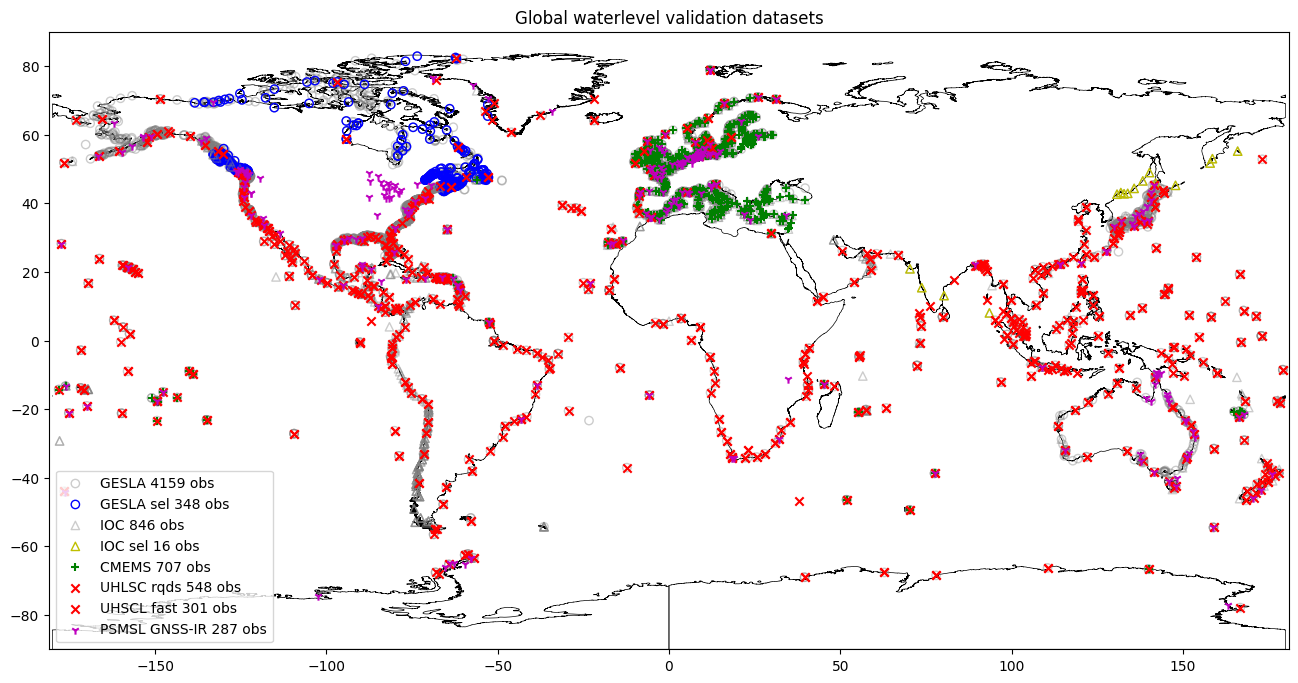

In [3]:
# plot stations
fig,ax = plt.subplots(figsize=(16,9))
gesla_catalog_gpd.geometry.plot(ax=ax, marker="o", color="grey", facecolor="none", label=f"GESLA {len(gesla_catalog_gpd)} obs", alpha=0.4)
gesla_catalog_gpd_sel.geometry.plot(ax=ax, marker="o", color="b", facecolor="none", label=f"GESLA sel {len(gesla_catalog_gpd_sel)} obs")
ioc_catalog_gpd.geometry.plot(ax=ax, marker="^", color="grey", facecolor="none", label=f"IOC {len(ioc_catalog_gpd)} obs", alpha=0.4)
ioc_catalog_gpd_sel.geometry.plot(ax=ax, marker="^", color="y", facecolor="none", label=f"IOC sel {len(ioc_catalog_gpd_sel)} obs")
cmems_list_gpd.geometry.plot(ax=ax, marker="+", color="g", label=f"CMEMS {len(cmems_list_gpd)} obs")
uhslc_json_rqds.geometry.plot(ax=ax, marker="x", color="r", label=f"UHLSC rqds {len(uhslc_json_rqds)} obs")
uhslc_json_fast.geometry.plot(ax=ax, marker="x", color="r", label=f"UHSCL fast {len(uhslc_json_fast)} obs")
psmsl_gnssir_gpd.geometry.plot(ax=ax, marker="1", color="m", label=f"PSMSL GNSS-IR {len(psmsl_gnssir_gpd)} obs")

ax.set_xlim(-181,181)
ax.set_ylim(-90,90)
ax.legend(loc=3)
ax.set_title("Global waterlevel validation datasets")
dfmt.plot_coastlines(ax=ax, min_area=1000, linewidth=0.5, zorder=0)


Next, we will subset all sources and retrieve and plot the sealevel data

retrieving psmsl-gnssir time extents for 5 stations: 1 2 3 4 5 
>> reading coastlines: 1.21 sec


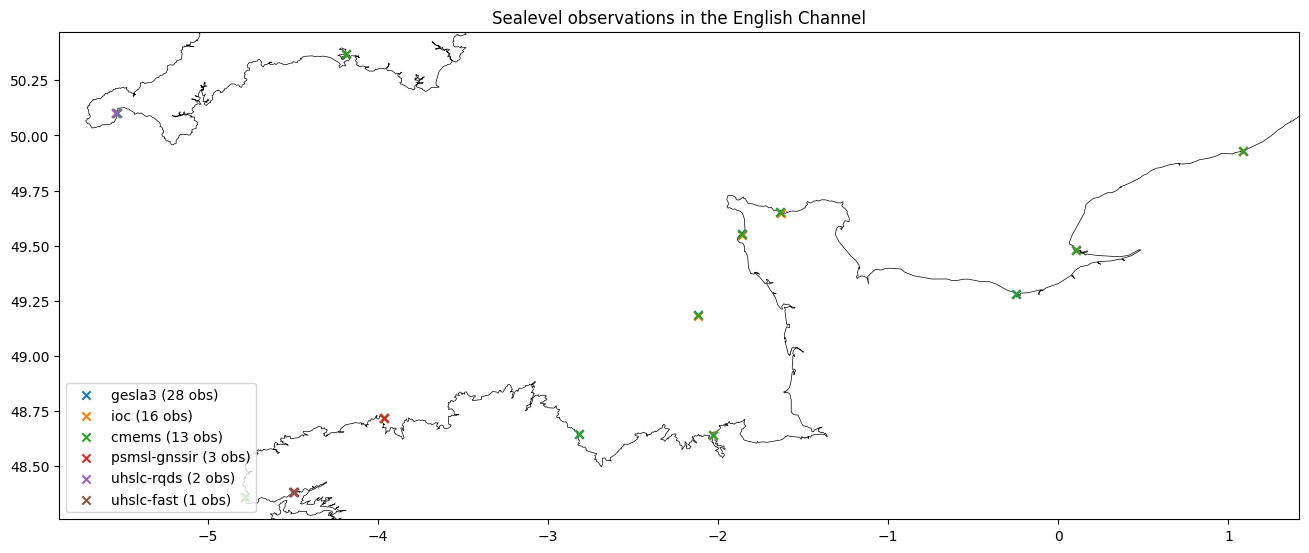

In [4]:
dir_output = "./sealevel_data_subset"
os.makedirs(dir_output, exist_ok=True)
lon_min, lon_max, lat_min, lat_max = -6, 5, 48, 50.5 # france
# lon_min, lon_max, lat_min, lat_max = 123, 148, 23, 47 # japan
# lon_min, lon_max, lat_min, lat_max = -20, 40, 25, 72 # europe
time_min, time_max = '2016-01-01','2016-02-01'

subset_kwargs = dict(lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max, 
                     time_min=time_min, time_max=time_max)
gesla_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='gesla3', **subset_kwargs)
ioc_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='ioc', **subset_kwargs)
cmems_list_gpd_sel = dfmt.ssh_catalog_subset(source='cmems', **subset_kwargs)
uhslc_json_rqds_sel = dfmt.ssh_catalog_subset(source='uhslc-rqds', **subset_kwargs)
uhslc_json_fast_sel = dfmt.ssh_catalog_subset(source='uhslc-fast', **subset_kwargs)
psmsl_gnssir_gpd_sel = dfmt.ssh_catalog_subset(source='psmsl-gnssir', **subset_kwargs)
subset_gpd_list = [gesla_catalog_gpd_sel, ioc_catalog_gpd_sel,
                  cmems_list_gpd_sel, psmsl_gnssir_gpd_sel,
                  uhslc_json_rqds_sel, uhslc_json_fast_sel]

# plot stations
fig,ax = plt.subplots(figsize=(16,9))
for subset_gpd in subset_gpd_list:
    source = subset_gpd.iloc[0]["source"]
    nstations = len(subset_gpd)
    subset_gpd.geometry.plot(ax=ax, marker="x", label=f"{source} ({nstations} obs)")
ax.legend(loc=3)
ax.set_title("Sealevel observations in the English Channel")
dfmt.plot_coastlines(ax=ax, min_area=1000, linewidth=0.5, zorder=0)


In [ ]:
# retrieve data (for all except gesla)
for subset_gpd in subset_gpd_list[1:]:
    dfmt.ssh_retrieve_data(subset_gpd, dir_output,
                           time_min=time_min, time_max=time_max)


retrieving data for 16 ioc stations:
cher: 2016-01 2016-02 
cher2: 2016-01 2016-02 
diel: 2016-01 2016-02 
diel2: 2016-01 2016-02 
diep: 2016-01 2016-02 
diep2: 2016-01 2016-02 
jers: 2016-01 2016-02 
leco: 2016-01 2016-02 
leco2: 2016-01 2016-02 
leha: 2016-01 2016-02 
leha2: 2016-01 2016-02 
plym: 2016-01 2016-02 
rosc: 2016-01 2016-02 
rosc2: 2016-01 2016-02 
stma: 2016-01 2016-02 
stma2: 2016-01 2016-02 
time extents supplied to 'cmems_ssh_retrieve_data()', tehse will be ignored.
retrieving data for 13 cmems stations: 1 2 3 4 5 6 7 8 9 10 11 12 13 
retrieving data for 3 psmsl-gnssir stations: 1 